In [1]:
from matplotlib import image
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.preprocessing import normalize
from dictlearn import DictionaryLearning, methods
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

p = 8 # dimensiunea unui patch (numar de pixeli)
s = 6 # sparsitatea
N = 1000 # numarul total de patch-uri
n = 256 # numarul de atomi din dictionar
K = 50 # numarul de iteratii DL
sigma = 0.075 # deviatia standard a zgomotului


## 1. Pregatirea imaginii.
### (a) Incarcati imaginea. Veti obtine imaginea I de dimensiune m1 × m2.

In [3]:
I = image.imread("barbara.png")
print("Imaginea are dimensiunea:", I.shape)

Imaginea are dimensiunea: (512, 512)


### (b) Adaugati zgomot cu dispersie σ imaginii, folosind secventa:
        Inoisy = I + sigma * np.random.randn(I.shape[0],I.shape[1])


In [4]:
Inoisy = I + sigma * np.random.randn(I.shape[0], I.shape[1])
Ynoisy = extract_patches_2d(Inoisy, (p, p))

### (c) Extrageti patch-urile din imaginea Inoisy si memorati-le in variabila Ynoisy. Functia extract_patches_2d va returna colectia de patch-uri, insa pentru a putea fi utilizate in continuare in antrenarea dictionarului e nevoie de ajustarea dimensiunii, respectiv de vectorizarea patch-urilor. Afisati intai dimensiunea Ynoisy. Pentru avectoriza patch-urile folositi:
        Ynoisy = Ynoisy.reshape(Ynoisy.shape[0], -1).
### Afisati din nou dimensiunea Ynoisy, pentru a observa rezultatul vectorizarii. Calculati media semnalelor pe linii (axa 0) si scadeti-o din Ynoisy, apoi transpuneti matricea.

In [5]:
print(Ynoisy.shape)
Ynoisy = Ynoisy.reshape(Ynoisy.shape[0], -1)
print(Ynoisy.shape)
mean = np.mean(Ynoisy, axis=0)
Ynoisy = Ynoisy.T - mean.reshape(-1, 1)
print(Ynoisy.shape)

(255025, 8, 8)
(255025, 64)
(64, 255025)


### (d) Selectati N patch-uri de dimensiune p la intamplare din imagine, obtinand astfel semnalele Y.
### Pentru aceasta, utilizati:
        numpy.random.choice(Ynoisy.shape[1],N)

In [6]:
Y = np.random.choice(Ynoisy.shape[1], N)
Y = Ynoisy[:,Y]

## 2. Antrenarea dictionarului.
### (a) Generati un dictionar aleator si normati coloanele, obtinand dictionarul D0.

In [7]:
D0 = np.random.randn(
    p * p,
    n
)

D0 = normalize(D0, axis=0, norm="max")

### (b) Antrenati dictionarul D pornind de la dictionarul D0 initializat mai sus, in K iteratii utilizand patch-urile selectate Y ca semnale de antrenare.

In [8]:
dl = DictionaryLearning(
    n_components=n,
    max_iter=K,
    fit_algorithm="ksvd",
    n_nonzero_coefs=s,
    code_init=None,
    dict_init=D0,
    params=None,
    data_sklearn_compat=False
)
dl.fit(Y)
D = dl.D_

## 3. Calcul reprezentarii rare si reconstructia imaginii.
### (a) Calculati reprezentarea rara a semnalelor Ynoisy, obtinand Xc.

In [9]:
Xc, err = methods.omp(Ynoisy, D, n_nonzero_coefs=s)
print(err)

0.9547940268204208


### (b) Obtineti patch-urile curate, Yc, utilizand dictionarul D si reprezentarea Xc, apoi adaugati media pe linii pe care ati scazut-o anterior.

In [10]:
print(Xc.shape)
print(D.shape)
Yc = np.dot(D, Xc)
print(Yc.shape)
Yc = Yc.T + mean
Yc = Yc.reshape(Yc.shape[0], p, p)

(256, 255025)
(64, 256)
(64, 255025)


### (c) Reconstruiti imaginea din patch-urile Yc, obtinand imaginea curata Ic.

In [11]:
Ic = reconstruct_from_patches_2d(Yc, (512, 512))

## 4. Evaluarea performantei.
### (a) Vizualizati cele trei imagini (originala, alterata de zgomot si curatata de zgomot). Pentru aceasta, folositi:
        plt.imshow(I)
### dupa ce ati incarcat pachetul:
        from matplotlib import pyplot as plt

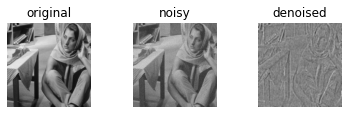

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3)
plt.subplots_adjust(wspace=0.5)
fig.add_subplot(ax[0])
plt.imshow(I, cmap="gray")
plt.axis("off")
plt.title("original")
fig.add_subplot(ax[1])
plt.imshow(Inoisy, cmap="gray")
plt.axis("off")
plt.title("noisy")
fig.add_subplot(ax[2])
plt.imshow(Ic, cmap="gray")
plt.axis("off")
plt.title("denoised")
plt.show()

### (b) Calculati psnr pentru a masura reducerea zgomotului. Calculati atat psnr intre imaginea originala si cea afectata de zgomot, cat si intre cea originala si cea in care ati eliminat zgomotul. Daca valoarea obtinuta pentru imaginea denoised este mai mare decat pentru cea noisy, metoda si-a indeplinit scopul.

In [13]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):
        return 0
    max_pixel = 255
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

print("noisy psnr: {}, denoised psnr: {}".format(psnr(I, Inoisy), psnr(I, Ic)))

noisy psnr: 70.62791148092826, denoised psnr: 60.91465768941619
